In [389]:
# compare most frequent words
# compare sentiment in most frequent common post size? in short posts?


# most frequent words in (1,2) or (1,3)


# look at results of drop stop stem text
#

# drop punctuation

# Comparing r/seattle and r/seattlewa

---

# Problem Statement

---

Describe Reddit

Interestingly, there are at least two subreddits for the city of Seattle: r/Seattle and r/SeattleWA. Our goal is to create an NLP model that will attempt to distinguish posts between these two subreddits. In the process, we hope to gain insight about why these two separate subreddits exist for the same city.

Classification model. This is a challenging problem, and there are certainly people who post in either subreddit without a considering why they are choosing one over the other. This is a level of randomness we do not know the size of and cannot eliminate in our examination. Since we should expect an accuracy of 50% without any help of a model, let us call success an accuracy above 70%.

---

## Imports and Functions

In [1]:
import requests
import time
from ratelimit import limits

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import re
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

In [2]:
def scrape_subreddit(subreddit):
    '''
    Given subreddit's name, request the most recent 2,250
    posts from the given subreddit.
    
    Combines the data into a csv file.
    '''
    
    url = 'https://api.pushshift.io/reddit/search/submission'
    params = {'subreddit': subreddit,
              'size': 250,
              'is_self': True,
              'selftext:not': '[removed]'}
    
    # assigns post data to variable 'posts'
    data = requests.get(url, params).json()
    posts = data['data']
    
    # adds the earliest post time to the 'before' API parameter
    # next request will collect posts before this time
    params['before'] = posts[-1]['created_utc']
    
    time.sleep(30)
    
    while len(posts) < 2_250:
        # collects next batch of posts data as 'next_posts'
        next_data = requests.get(url, params).json()
        next_posts = next_data['data']
        
        # concatenate posts data to 'posts'
        posts += next_posts
        
        # update API parameters to so the following 250 posts
        # will be requested in the next iteration of the loop
        earliest_post_time = next_posts[-1]['created_utc']
        params['before'] = earliest_post_time
        
        # delay next request and not spam the API
        time.sleep(30)
        
    posts_df = pd.DataFrame(posts)
    posts_df.to_csv(f'datasets/{subreddit}.csv', index = False)
    

def text_cleaning(text):
    '''
    Cleans text by removing [bracketed statements], urls, emails,
    some special characters (parentheses and stars), and some common html phrases.
    
    Returns the cleaned text
    '''
    
    # remove new lines
    text = re.sub('\n', ' ', text)
    
    # remove parentheses and asterisks
    text = re.sub("[\(\)\*]", '', text)
    
    # remove urls and do not include closing bracket ]
    text = re.sub('http\S+|www\.\S+', '', text)
    
    # remove bracketed strings
    text = re.sub('\[(\w|\s)*\]', '', text)
    
    # remove any leftover brackets
    text = re.sub('[\[\]]', '', text)
    
    # replace parentheses with spaces
    text = re.sub("/", ' ', text)
    
    # remove some common html phrases
    text = re.sub('&(gt|lt);', '', text)
    text = re.sub('&amp;', '', text)
    text = re.sub('&?#x200b;?', '', text)
    text = re.sub('&?#x200B;?', '', text)
    
    # remove email accounts
    text = re.sub('\S+@\S+', '', text)
    
    # replace whitespace with single space
    text = re.sub('\s+', ' ', text)
        
    return text


# although stop_drop_and_stem is a cooler name
# it would be slightly less clear :(
def drop_stop_and_stem(text):
    '''
    Takes a string, drops the stop words,
    and stems the remaining words with PorterStemmer.
    
    Returns the stemmed, non-stopwords
    '''
    
    pstem = PorterStemmer()
    
    #stem non-stopwords and put into a list
    stemmed_list = [pstem.stem(word) for word in text.split()
                    if word not in stopwords.words('english')]
    
    # return words separated by a space
    return ' '.join(stemmed_list)


def create_sentiment(df):
    '''
    Using Vader, collects sentiment from a DataFrame's "text" column.
    Creates three new columns titled "sent_pos", "sent_neg", and "sent_comp" from the 
    positive, negative, and compound sentiment scores.
    
    Returns the DataFrame with additional columns "sent_pos", "sent_neg", and "sent_comp".
    '''
    
    sent = SentimentIntensityAnalyzer()
    
    df['sent_pos'] = df['text'].apply(lambda x: sent.polarity_scores(x)['pos'])
    df['sent_neg'] = df['text'].apply(lambda x: sent.polarity_scores(x)['neg'])
    df['sent_compound'] = df['text'].apply(lambda x: sent.polarity_scores(x)['compound'])
    

def sample_three(series):
    '''
    Prints three random entries from a given series.
    '''
    for entry in series.sample(3):
        print(entry)
        print('----------\n')

In [3]:
# collect more than 2,250 posts from /r/Seattle and /r/SeattleWA subreddits
# commented out because the data has already been collected

#scrape_subreddit('Seattle')
#scrape_subreddit('SeattleWA')

---

## Basic Cleaning

In [4]:
sea = pd.read_csv('datasets/Seattle.csv')
sea_wa = pd.read_csv('datasets/SeattleWA.csv')

Through reading the two csv files I identified the columns below would be most relevant in search.

In [5]:
# columns of interest
init_cols = ['subreddit', 'author', 'created_utc', 'title', 'selftext']

sea = sea[init_cols].copy()
sea_wa = sea_wa[init_cols].copy()

Let us see if there are any blatant things to clean in the data.

In [6]:
sea.isnull().sum()

subreddit      0
author         0
created_utc    0
title          0
selftext       0
dtype: int64

In [7]:
sea_wa.isnull().sum()

subreddit      0
author         0
created_utc    0
title          0
selftext       3
dtype: int64

In [8]:
print(sea.shape)
print(sea_wa.shape)

(2499, 5)
(2499, 5)


In [9]:
sea_wa.dropna(inplace = True)

There should not be any harm in removing three entries with missing selftext data out of nearly 2,500 posts.

Since we will eventually want to look over text from both title and selftext, let us concatenate these columns.

In [10]:
# create a new column from joining title text and selftext
sea['text'] = sea['title'] + ' ' + sea['selftext']
sea_wa['text'] = sea_wa['title'] + ' ' + sea_wa['selftext']

Next we clean need to clean the data. Below we our `text_cleaning` function to do basic cleaning like remove urls, select special characters, and bracketed text.

After cleaning we will collect sentiment from our text through `vader`, then drop stopwords, and finally stem. We collect sentiment first because `vader` may have trouble performing sentiment analysis on stemmed text.

In [11]:
# remove urls and emails, special characters ()/*, and [bracketed strings]
sea['text'] = sea['text'].apply(text_cleaning)
sea_wa['text'] = sea_wa['text'].apply(text_cleaning)

In [12]:
# in place methods that generate positive and negative sentiment scores
# for the given dataframes
create_sentiment(sea)
create_sentiment(sea_wa)

In [13]:
# count number of words by splitting text across white space and recording list length
sea['word_count'] = sea['text'].str.split().str.len()
sea_wa['word_count'] = sea_wa['text'].str.split().str.len()

In [14]:
sea_wa.head()

,subreddit,author,created_utc,title,selftext,text,sent_pos,sent_neg,sent_compound,word_count
0,SeattleWA,Sinkholediaries,1664416603,Archspire fans?,I'm a lady who is obsessed. I need other frien...,Archspire fans? I'm a lady who is obsessed. I ...,0.206,0.284,-0.4939,31
1,SeattleWA,prf_q,1664406559,Is it the overseeding season yet?,Those who are maintaining a lawn: Are you over...,Is it the overseeding season yet? Those who ar...,0.069,0.000,0.3485,35
2,SeattleWA,eatmoremeatnow,1664404071,Showbox Box Office?,Has anybody recently bought a ticket from the ...,Showbox Box Office? Has anybody recently bough...,0.034,0.058,-0.3270,55
3,SeattleWA,xixi90,1664398109,[Public Policy Poll] Patty Murray (D) leads Ti...,https://www.publicpolicypolling.com/wp-content...,Patty Murray D leads Tiffany Smiley R 52.0 - ...,0.114,0.000,0.4019,25
4,SeattleWA,irish_gnome,1664320032,Gas prices going back up?,Just watched the local gas station raise their...,Gas prices going back up? Just watched the loc...,0.000,0.084,-0.3736,29


In [15]:
# clean up print statements and rerun fresh
print(sea[sea['text'].duplicated()].sort_values(by = 'author').shape)
print(sea_wa[sea_wa['text'].duplicated()].sort_values(by = 'author').shape)
sea_wa[sea_wa['text'].duplicated()].sort_values(by = 'author').head(10)

(5, 10)
(38, 10)


,subreddit,author,created_utc,title,selftext,text,sent_pos,sent_neg,sent_compound,word_count
407,SeattleWA,AceItAcademy,1660688425,Ace It Academy - A newly opened tutoring servi...,&amp;#x200B;\n\nhttps://preview.redd.it/zn19ut...,Ace It Academy - A newly opened tutoring servi...,0.025,0.0,0.3802,110
97,SeattleWA,AutoModerator,1663238408,Seattle Reddit Community Open Chat,Welcome to the [Seattle Reddit Community](http...,Seattle Reddit Community Open Chat Welcome to ...,0.084,0.0,0.8388,112
2328,SeattleWA,AutoModerator,1646912409,Seattle Reddit Community Open Chat,Welcome to the [Seattle Reddit Community](http...,Seattle Reddit Community Open Chat Welcome to ...,0.084,0.0,0.8388,112
2197,SeattleWA,AutoModerator,1647513608,Seattle Reddit Community Open Chat,Welcome to the [Seattle Reddit Community](http...,Seattle Reddit Community Open Chat Welcome to ...,0.084,0.0,0.8388,112
2119,SeattleWA,AutoModerator,1648118409,Seattle Reddit Community Open Chat,Welcome to the [Seattle Reddit Community](http...,Seattle Reddit Community Open Chat Welcome to ...,0.084,0.0,0.8388,112
2024,SeattleWA,AutoModerator,1648723209,Seattle Reddit Community Open Chat,Welcome to the [Seattle Reddit Community](http...,Seattle Reddit Community Open Chat Welcome to ...,0.084,0.0,0.8388,112
1944,SeattleWA,AutoModerator,1649328010,Seattle Reddit Community Open Chat,Welcome to the [Seattle Reddit Community](http...,Seattle Reddit Community Open Chat Welcome to ...,0.084,0.0,0.8388,112
1887,SeattleWA,AutoModerator,1649932809,Seattle Reddit Community Open Chat,Welcome to the [Seattle Reddit Community](http...,Seattle Reddit Community Open Chat Welcome to ...,0.084,0.0,0.8388,112
1798,SeattleWA,AutoModerator,1650537609,Seattle Reddit Community Open Chat,Welcome to the [Seattle Reddit Community](http...,Seattle Reddit Community Open Chat Welcome to ...,0.084,0.0,0.8388,112
1716,SeattleWA,AutoModerator,1651142410,Seattle Reddit Community Open Chat,Welcome to the [Seattle Reddit Community](http...,Seattle Reddit Community Open Chat Welcome to ...,0.084,0.0,0.8388,112


In [16]:
sea.drop_duplicates('text', inplace = True)
sea_wa.drop_duplicates('text', inplace = True)

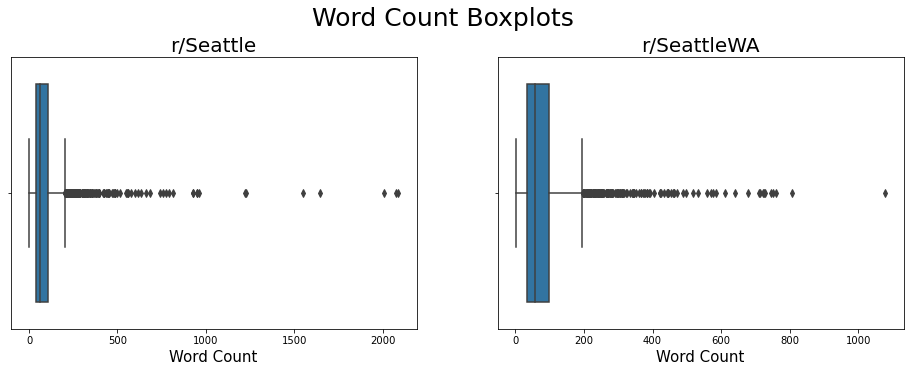

In [17]:
fig, axes = plt.subplots(1,2, figsize = (16,5))

fig.suptitle('Word Count Boxplots', size = 25, y = 1.02)
sns.boxplot(x = sea['word_count'], ax = axes[0])
axes[0].set_title('r/Seattle', size = 20)
axes[0].set_xlabel('Word Count', size = 15)

sns.boxplot(x = sea_wa['word_count'], ax = axes[1])
axes[1].set_title('r/SeattleWA', size = 20)
axes[1].set_xlabel('Word Count', size = 15);

In [18]:
sea['word_count'].describe()

count    2494.000000
mean       93.418605
std       127.140183
min         0.000000
25%        39.000000
50%        62.000000
75%       104.750000
max      2088.000000
Name: word_count, dtype: float64

Let us explore these extraordinarily long posts.

In [19]:
for entry in sea.loc[sea['word_count'] > 1500, 'text']:
    print(entry)
    print('-------\n')

Seattle City Council Newsletters!! Reddit: Hey everyone! I just wanted to introduce myself again. My name is George, and I am a rising junior at Stanford interested in civic engagement and politics. I started working on a project with other students that’s been totally awesome and cool. Basically, we’ve made a newsletter that summarizes the info from Seattle City Council meetings in an accessible and easy way. I have put an example from this week below, though the real thing has a bit more formatting that doesn't translate into Reddit. This project is very new, so we would really appreciate any feedback you may have! I would love to see comments and show me what I need to do to make this newsletter the best it can be. I totally recommend joining! Who doesn’t want to know what goes on behind the scenes of their own beautiful city? If you are interested in receiving these weekly in your email inbox, you can click this link: Example Newsletter: Seattle City Council Meeting Summaries - Wee

The only posts that immediately seem worthwhile dropping are the City Council Newsletter post and the post referring to Uvalde police. The City Council post seems to contain very specialized vocabulary and is lengthy by the nature of the post. These posts also seem regular though, so it would be out of place to drop just this especially lengthy post and not the other posts. Dropping all City Council posts by this person seems a bit excessive, so we will leave the City Council posts in.

There are two posts about Uvalde police. They appear to be identical except for some select words and some repeated characters that are used to distinguish the heading and body. I am sure there are more posts that are slightly off from being identical. We cannot remove them all, but since we stumbled upon this pair, we may as well remove one of them.

In [20]:
print(sea[sea['text'].str.contains('SPD should be barred from')].index)
sea.drop(index = 542, inplace = True)

Int64Index([536, 542], dtype='int64')


In [21]:
for entry in sea_wa.loc[sea_wa['word_count'] > 1000, 'text']:
    print(entry)
    print('-------\n')

Using Affordable Housing to get on The Property Ladder in Seattle. The median home price in Seattle is now $934K. A few years back I decided to settle down and buy a house, but I couldn't come up with $200K for a down payment. I used a fairly convoluted method to deal with that. Someone on the forum asked me to elaborate how and why I did that, so I thought I'd make a post. When we started dating, we were looking at places that were really farther from Seattle than is ideal. Even places in Lynnwood were stretching our budget. We were in a conundrum, where it felt like our only option was having some nightmarish commute from Everett, or renting indefinitely. When the median home price in Seattle was $449K, it was $182K in Las Vegas. So we bought a place out there, and rented it out. Homes were so cheap, one of the problems we had was getting financing. Not because we couldn't qualify. But because the loans were so small the banks didn't want to do them. I learned that banks basically wo

Nothing about the lengthiest post in r/SeattleWA suggests it needs to be removed. Let us leave it in.

Next let us look at posts that are too short to reasonably use. The only post that obviously should be removed is the empty one at index 1191. It is empty because it only contained urls.

In [22]:
sea.loc[sea['word_count'] < 10, 'text']

400                   The West Seattle Bridge is OPEN!!! 
423     What’s with the Fighter jets over south seattl...
435           How has Seattle changed over the years? ..?
768                              Earthquake ? around 1:08
805                        Hi All Anyone from Kiingston ?
1191                                                     
1292                               Weaponizing your pets 
1346    Employment discrimination lawyer? Any recommen...
1422                                Yo Seattle area 🔌 hmu
1425          Where’s the best quesadilla in town? Title.
1748                    hey guys I just wanted to say hey
1755        How’s the comedy scene here? Need some laughs
1766    Seattle passes protections for abortion and ge...
1775    Best junkyards to pull parts from, recommendat...
1782                            It’s thunder. Move along.
1838                             It's raining That's all.
2277                    Somen soba in the city? Any recs?
2337          

In [23]:
sea.loc[1191,['title','selftext','text']]

title       https://get.stash.com/gabrieldqpkk
selftext    https://get.stash.com/gabrieldqpkk
text                                          
Name: 1191, dtype: object

In [24]:
sea.drop(index = 1191, inplace = True)

For r/SeattleWA we can already see a pretty big difference in the number of posts with fewer than 10 words and their content compared to r/Seattle. No posts here seem to require being dropped. Even the shorter posts convey a fair bit of sentiment.

In [25]:
sea_wa.loc[sea_wa['word_count'] < 10, 'text']

5       Shooting near pioneer square Around 3:30 pm to...
6                             Shooting in Pioneer square 
38          Will piss mania come to seattle??? Piss mania
104                                  Another 1. Shooting 
142            Inslee ending Covid-19 state of emergency 
149     What is considered greater Seattle??? What’s c...
194                      Moderators what did I now? ?????
235      Yup, great minds coming through with the next...
322                                          it's ironic 
323                                         Pepe Silvia? 
373         Saxophone Anyone down to teach me saxophone ?
389     any ideas what happened here? Processing img 8...
403     didn't realize they put coloring books on the ...
430                                        Bye, Felicia! 
607     Any breakfast recommendations on the eastside?...
612                   Is this Seattle's signature scent? 
749     Best sunrise spots nearby city Any recommendat...
751     Seattl

In [401]:
sample_three(sea_wa['text'])

went woodland zoo first time visit seattl recent and wow… i live vancouv canada amaz clean well kept zoo is. blow park make even question zoo. the staff volunt realli care feel like washington feel differ compar state i to. way differ vancouv bc well. you guy popul outsid seattl proper nice well kept. the qualiti live much better compar bc state.
----------

look survivor in 2020 i sexual assault dr pacif medic center dermatology. i’m consid pursu legal action wonder there’ anyon els may similar experi mad i am. feel free pm don’t feel comfort comment publicly.
----------

garag estat sale weekend where garag sale weekend??
----------



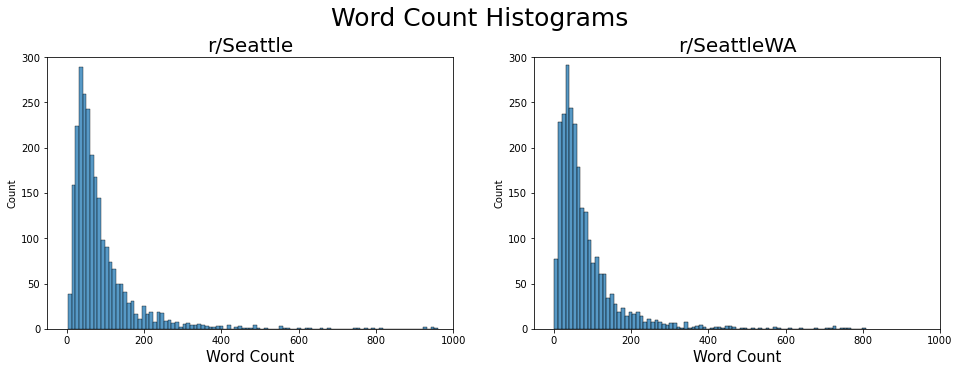

In [392]:
fig, axes = plt.subplots(1,2, figsize = (16,5))

# saw earlier that r/seattle has more posts with very high word counts
# let us compare the distribution of posts with word counts below 1000

sea_sub_1000 = sea[sea['word_count'] < 1000]
sea_wa_sub_1000 = sea_wa[sea_wa['word_count'] < 1000]

fig.suptitle('Word Count Histograms', size = 25, y = 1.02)
sns.histplot(x = sea_sub_1000['word_count'], ax = axes[0])
axes[0].set_title('r/Seattle', size = 20)
axes[0].set_xlabel('Word Count', size = 15)
axes[0].set_xlim(-50, 1000)
axes[0].set_ylim(-0, 300)

sns.histplot(x = sea_wa_sub_1000['word_count'], ax = axes[1])
axes[1].set_title('r/SeattleWA', size = 20)
axes[1].set_xlabel('Word Count', size = 15)
axes[1].set_xlim(-50, 1000)
axes[1].set_ylim(-0, 300);

The histogram shapes are nearly identical between the two subreddits.

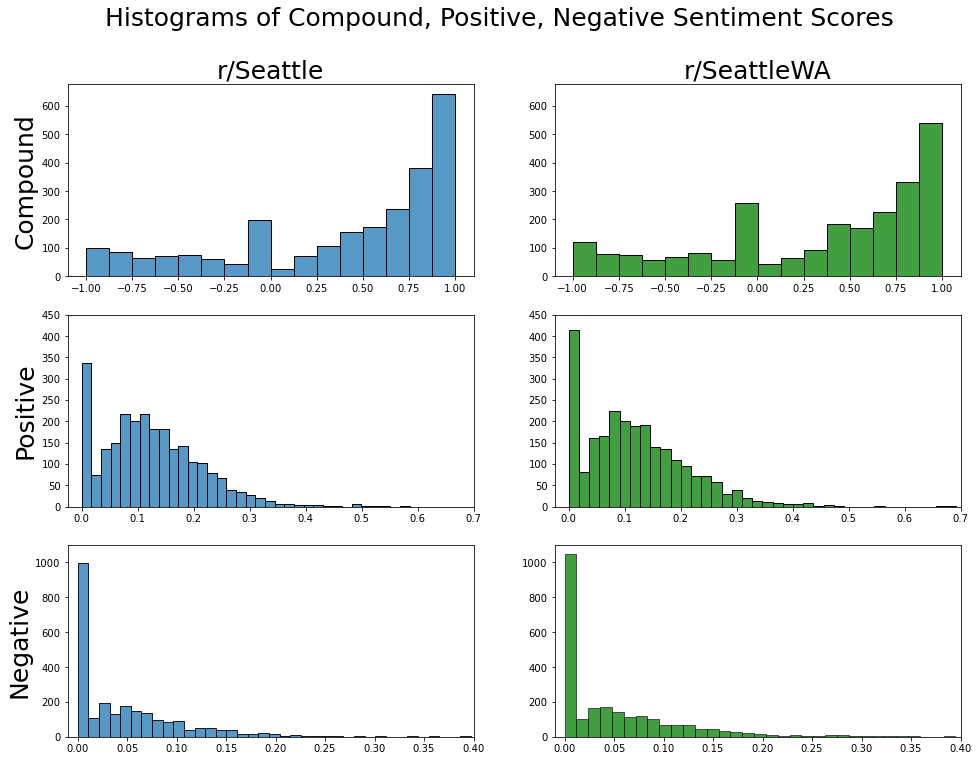

In [27]:
#from matplotlib.lines import Line2D

fig, axes = plt.subplots(3,2, figsize = (16,12))

fig.suptitle('Histograms of Compound, Positive, Negative Sentiment Scores', size = 25, y = 0.97)

#---------------------------
# r/Seattle sentiment scores
#---------------------------
sns.histplot(x = sea['sent_compound'], ax = axes[0,0])
axes[0,0].set_title('r/Seattle', size = 25)
axes[0,0].set_xlabel('', size = 15)
axes[0,0].set_ylabel('Compound', size = 25)
axes[0,0].set_ylim(0, 675)

sns.histplot(x = sea['sent_pos'], ax = axes[1,0])
#axes[1,0].set_title('Positive', size = 20)
axes[1,0].set_xlabel('', size = 15)
axes[1,0].set_ylabel('Positive', size = 25)
axes[1,0].set_xlim(-0.025, 0.7)
axes[1,0].set_ylim(0, 450)

sns.histplot(x = sea['sent_neg'], ax = axes[2,0])
#axes[2,0].set_title('Negative', size = 20)
axes[2,0].set_xlabel('', size = 15)
axes[2,0].set_ylabel('Negative', size = 25)
axes[2,0].set_xlim(-0.01, 0.4)
axes[2,0].set_ylim(0, 1100)


#-------------------------------
# # r/SeattleWA sentiment scores
#-------------------------------
sns.histplot(x = sea_wa['sent_compound'], ax = axes[0,1], color = 'green')
axes[0,1].set_title('r/SeattleWA', size = 25)
axes[0,1].set_xlabel('', size = 15)
axes[0,1].set_ylabel('', size = 15)
axes[0,1].set_ylim(0, 675)

sns.histplot(x = sea_wa['sent_pos'], ax = axes[1,1], color = 'green')
#axes[1,1].set_title('r/Seattle', size = 20)
axes[1,1].set_xlabel('', size = 15)
axes[1,1].set_ylabel('', size = 15)
axes[1,1].set_xlim(-0.025, 0.7)
axes[1,1].set_ylim(0, 450)

sns.histplot(x = sea_wa['sent_neg'], ax = axes[2,1], color = 'green')
#axes[1,2].set_title('r/Seattle', size = 20)
axes[2,1].set_xlabel('', size = 15)
axes[2,1].set_ylabel('', size = 15)
axes[2,1].set_xlim(-0.01, 0.4)
axes[2,1].set_ylim(0, 1100);

# custom legend
# legend_elements = [Line2D([0], [0], color='tab:blue', lw=4, label='r/Seattle'), 
#                    Line2D([0], [0], color='tab:green', lw=4, label='r/SeattleWA'),]

# legend = axes[2,1].legend(handles = legend_elements, fontsize = 20);

The above plots show that the sentiment scores between r/Seattle and r/SeattleWA look very similar. The most notable differences are:
- the highest compound scores appear more frequently in r/Seattle
- the lowest positive scores appear more frequently in r/SeattleWA
- the higher negative scores appear slightly more frequently in r/SeattleWA

In [28]:
# drop stopwords and then stem the text data
sea['text'] = sea['text'].apply(drop_stop_and_stem)
sea_wa['text'] = sea_wa['text'].apply(drop_stop_and_stem)

In [29]:
sea.drop(columns = ['title', 'selftext'], inplace = True)
sea_wa.drop(columns = ['title', 'selftext'], inplace = True)

#### Most Frequent Words

In [454]:
cvec = CountVectorizer(max_features = 2000)
#sea_wa_cvec = CountVectorizer(stop_words='english')

# collect 2,000 most frequent words appearing in r/Seattle
sea_word_freq = cvec.fit_transform(sea['text'])
sea_word_freq = pd.DataFrame(sea_word_freq.todense(), columns = cvec.get_feature_names_out())
sea_words_top_2k = sea_word_freq.sum().sort_values(ascending = False)

# collect 2,000 most frequent words appearing in r/SeattleWA
sea_wa_word_freq = cvec.fit_transform(sea_wa['text'])
sea_wa_word_freq = pd.DataFrame(sea_wa_word_freq.todense(), columns = cvec.get_feature_names_out())
sea_wa_words_top_2k = sea_wa_word_freq.sum().sort_values(ascending = False)

In [455]:
sea_words_top_2k.head(15)

seattl     1545
get         981
it          960
like        957
would       867
look        832
go          810
know        804
anyon       748
place       655
want        621
we          605
seattle     597
time        591
area        571
dtype: int64

In [456]:
sea_wa_words_top_2k.head(15)

seattl    1342
look       791
like       788
get        779
it         714
would      713
know       663
go         650
anyon      643
area       562
peopl      557
place      544
the        540
live       516
want       508
dtype: int64

In [457]:
# collect the top 15 words in each subreddit
sea_top_15 = set(sea_words_top_2k.head(15).index)
sea_wa_top_15 = set(sea_wa_words_top_2k.head(15).index)

# collect the words that appeared in one subreddit's top 15 list and not the other
only_sea_top_15 = sea_top_15 - sea_top_15.intersection(sea_wa_top_15)
only_sea_wa_top_15 = sea_wa_top_15 - sea_top_15.intersection(sea_wa_top_15)

print(only_sea_top_15)
print(only_sea_wa_top_15)

{'we', 'time', 'seattle'}
{'the', 'peopl', 'live'}


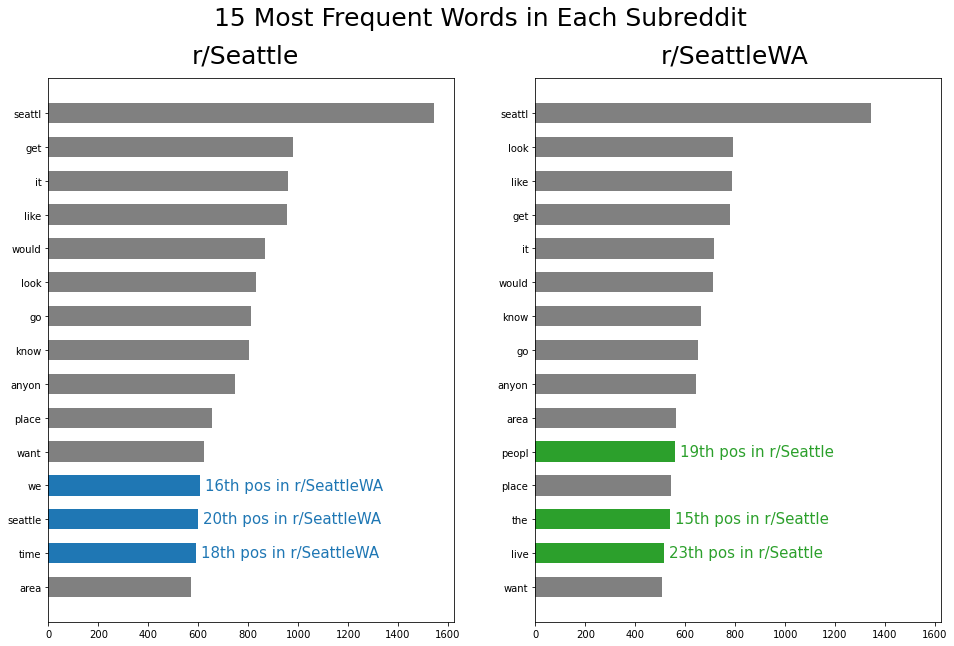

In [458]:
plt.figure(figsize = (16,10))

# Title
plt.suptitle('15 Most Frequent Words in Each Subreddit', size = 25)


'''
left subplot for r/Seattle 
'''
plt.subplot(1,2,1)
# subtitle
plt.text(s = 'r/Seattle', x = 575, y = 15.5, size = 25)

# plot grey bars 
plt.barh(y = sea_words_top_2k.head(15).index[::-1], width = sea_words_top_2k.head(15).values[::-1], height = 0.6, color = 'grey')
plt.xlim([0, 1625])

# plot blue highlighted bars that do not appear in r/SeattleWA top 15
for word in only_sea_top_20:
    
    # obtains y-value of word for horizontal bar chart
    # value is the word frequency (size of the bar)
    pos = 14 - sea_words_top_2k.index.get_loc(word)
    value = sea_words_top_2k[word]
    plt.barh(y = pos, width = value, height = 0.6, color = 'tab:blue')
    
    # plot text of word's position in r/SeattleWA
    sea_wa_pos = sea_wa_words_top_2k.index.get_loc(word)
    plt.text(x = value + 20, y = pos - 0.125, s = f'{sea_wa_pos}th pos in r/SeattleWA', color = 'tab:blue', size = 15)

    
'''
right subplot for r/SeattleWA
'''
plt.subplot(1,2,2)
# r/SeattleWA subtitle
plt.text(s = 'r/SeattleWA', x = 500, y = 15.5, size = 25)

# plot grey bars
plt.barh(y = sea_wa_words_top_2k.head(15).index[::-1], width = sea_wa_words_top_2k.head(15).values[::-1], height = 0.6, color = 'grey')
plt.xlim([0,1625])

# plot green highlighted bars that do not appear in r/Seattle top 15
for word in only_sea_wa_top_20:
    
    # obtains y-value of word for horizontal bar chart
    # value is the word frequency (size of the bar)
    pos = 14 - sea_wa_words_top_2k.index.get_loc(word)
    value = sea_wa_words_top_2k[word]
    plt.barh(y = pos, width = value, height = 0.6, color = 'tab:green')
    
    # plot text of word's position in r/Seattle
    sea_pos = sea_words_top_2k.index.get_loc(word)
    plt.text(x = value + 20, y = pos - 0.125, s = f'{sea_pos}th pos in r/Seattle', color = 'tab:green', size = 15);

The 15 most common words for the two subreddits are quite uninteresting and not very informative. Moreover, the differences between the two are quite small. The words that appear in one subreddits top 15 but not the other are only a little further down the list. We also see 'seattl' and 'seattle' as two distinct words after stemming. This is unfortunate, but it is not worth taking the time to resolve.

Although the above image does not show us anything interesting, it does give us an interesting direction to examine - if words were ranked by their frequencies within each subreddit, how much would the rankings differ?

To answer this question our strategy will be:
- find the words in common between the two lists
- rank each word from most frequent to least frequent within each subreddit
- subtract the rankings for only these words in common

First we find the words that appear in both subreddits' top 2000 list.

In [459]:
# form a set of each subreddits top 2000 words
sea_words_set = set(sea_words_top_2k.index)
sea_wa_words_set = set(sea_wa_words_top_2k.index)

# collect the words that are in common (1636 words)
words_in_common = sea_words_set.intersection(sea_wa_words_set)

print(f"There are {len(words_in_common)} words in common between r/Seattle and r/SeattleWA's top 2,000 words")

There are 1636 words in common between r/Seattle and r/SeattleWA's top 2,000 words


We already have our two thousand most common words for each subreddit, and they are already ordered. To create of word rankings, we can reuse our ordered word frequency series. The only difference is that the values in the series will increase by one for each word except when the frequencies are the same.

In [460]:
# create blank series for recording rank
# started with indices that match the sorted word frequency series 
sea_words_ranking = pd.Series(index = sea_words_top_2k.index, dtype = int)
sea_wa_words_ranking = pd.Series(index = sea_wa_words_top_2k.index, dtype = int)

In [461]:
# assign rankings to r/Seattle words
ranking = 1
prev_freq = sea_words_top_2k[0]

for index, current_freq in enumerate(sea_words_top_2k):
    if current_freq < prev_freq:
        ranking += 1
        
    sea_words_ranking[index] = ranking
    prev_freq = current_freq

In [462]:
# assign rankings to r/SeattleWA words
ranking = 1
prev_freq = sea_wa_words_top_2k[0]

for index, current_freq in enumerate(sea_wa_words_top_2k):
    if current_freq < prev_freq:
        ranking += 1
        
    sea_wa_words_ranking[index] = ranking
    prev_freq = current_freq

Below we see the general structure of the word rankings for r/Seattle and r/SeattleWA.

In [463]:
sea_words_ranking.sort_values()

seattl         1.0
get            2.0
it             3.0
like           4.0
would          5.0
             ...  
punk         247.0
corner       247.0
ratifi       247.0
shown        247.0
reference    247.0
Length: 2000, dtype: float64

In [464]:
sea_wa_words_ranking.sort_values()

seattl       1.0
look         2.0
like         3.0
get          4.0
it           5.0
           ...  
featur     224.0
achiev     224.0
popular    224.0
freak      224.0
00         224.0
Length: 2000, dtype: float64

It is only clear what the difference in rankings would mean for words that are in appear in both sets. Let us subset our two ranking series over the common words and sort over the index. This way, the indices will match and we can directly subtract the two series to obtain the ranking differences.

In [465]:
# convert common words from a set to list so we can index our ranking series over them
words_in_common = list(words_in_common)

# index two word ranking series over common words and sort index
# so the indices of rankings match for the two subreddits
sea_common_ranking = sea_words_ranking[words_in_common].sort_index()
sea_wa_common_ranking = sea_wa_words_ranking[words_in_common].sort_index()

In [466]:
sea_common_ranking

00       241.0
000      230.0
10       137.0
100      210.0
11       215.0
         ...  
you       61.0
young    228.0
your     243.0
zero     244.0
zone     238.0
Length: 1636, dtype: float64

In [467]:
sea_wa_common_ranking

00       224.0
000      193.0
10       124.0
100      179.0
11       205.0
         ...  
you       51.0
young    175.0
your     205.0
zero     219.0
zone     219.0
Length: 1636, dtype: float64

Now we are set up to compute the ranking differences between the subreddits.

In [471]:
ranking_difference = (sea_common_ranking - sea_wa_common_ranking).sort_values()

Of course this list is too long to examine in its entirety (1636 words). We print out fifty words with the largest negative ranking difference and fify words with the largest positive ranking differences. Even this is a bit long, but because this is one of the major conclusions of our analysis, it seems worthwhile to offer the most information here.

Note that because a lower value for word ranking corresponds to higher word frequency in the subreddit, the more negative this difference is, the more the word appeared in the r/Seattle subreddit. The more positive this difference is, the more the word appeared in the r/Seattle subreddit.

In [472]:
ranking_difference.head(50)

board      -56.0
game       -54.0
food       -52.0
dog        -51.0
line       -46.0
event      -43.0
visit      -32.0
late       -31.0
district   -31.0
local      -30.0
relat      -27.0
plan       -27.0
wonder     -25.0
night      -24.0
light      -24.0
next       -24.0
song       -24.0
kind       -23.0
polic      -23.0
blue       -22.0
shop       -20.0
he         -19.0
mayb       -19.0
where      -19.0
public     -19.0
big        -18.0
bring      -18.0
coffe      -18.0
train      -17.0
rail       -17.0
tell       -17.0
els        -16.0
group      -16.0
friend     -16.0
specif     -16.0
option     -16.0
us         -16.0
worth      -15.0
show       -14.0
transit    -14.0
question   -14.0
love       -14.0
sinc       -13.0
park       -12.0
meet       -12.0
develop    -12.0
but        -12.0
hour       -12.0
pretti     -12.0
buy        -11.0
dtype: float64

In [473]:
ranking_difference.tail(50).sort_values(ascending = False)

mask          98.0
tax           79.0
washington    62.0
june          61.0
homeless      60.0
offer         59.0
state         58.0
drug          56.0
2021          56.0
dental        55.0
sub           55.0
report        54.0
young         53.0
wear          52.0
polit         52.0
anoth         52.0
wa            52.0
crime         52.0
manag         51.0
student       50.0
juli          50.0
summer        48.0
bellevue      47.0
kent          46.0
includ        46.0
properti      46.0
law           46.0
gun           45.0
nearbi        45.0
later         45.0
high          45.0
clean         44.0
ticket        44.0
contact       44.0
second        44.0
beach         43.0
read          43.0
women         43.0
months        43.0
today         43.0
men           42.0
valu          42.0
counti        42.0
king          42.0
credit        42.0
ga            41.0
stolen        41.0
inform        41.0
sale          41.0
test          41.0
dtype: float64

One thing to notice is that there are many more large positive values that resulted from this difference. It is hard to know why this was the case. One possible explanation may be that there were a number of more specialized words that appeared with higher frequency on the r/SeattleWA list while the r/Seattle list contained more general words. This would mean that many of the words top words from r/Seattle were still distributed throughout the top words in r/SeattleWA, but the reverse would not be true.

We can see this a bit with words that appeared more in **r/Seattle**:
- board
- game 
- food
- dog 
- event

whereas the words that appeared more in **r/SeattleWA**: 
- mask
- tax
- washington
- homeless
- drug
- report
- polit 
- crime
- law
- gun
- stolen

In [475]:
# elements in top 2000 words of one subreddit but not the other
sea_only_words_list = list(sea_words_set - set(words_in_common))
sea_wa_only_words_list = list(sea_wa_words_set - set(words_in_common))

In [280]:
len(sea_only_words_list)

364

In [476]:
sea_words_top_2k[sea_only_words_list].sort_values(ascending = False).head(25)

councilmemb    116
sponsor         56
weekli          46
ye              36
track           32
roll            32
adopt           31
faq             30
zoo             30
optim           30
donat           30
ordin           30
plane           29
amend           28
meetup          28
author          28
2023            27
stick           27
happening       24
suburb          24
those           24
director        24
establish       24
wide            23
built           23
dtype: int64

In [477]:
sea_wa_words_top_2k[sea_wa_only_words_list].sort_values(ascending = False).head(25)

march       39
kids        29
blog        29
april       29
patient     28
migrat      28
client      23
4th         23
teach       22
peac        22
remot       22
vegan       21
john        21
99          20
crisi       20
mandat      20
ban         20
broke       20
particip    19
maintain    19
assault     19
discount    19
wsdot       19
solut       18
tv          18
dtype: int64

We see councilmemb appear quite a bit in r/Seattle and not appear in r/SeattleWA. This was because there was a Stanford student who would regularly post details about City Council meetings in r/Seattle.

Higher values mean that the word appeared more frequently in r/SeattleWA, lower values mean the word appeared more frequently in r/Seattle.

In [274]:
ranking_difference[ranking_difference.between(-1,1)]

check         -1.0
car           -1.0
ll            -1.0
one           -1.0
go            -1.0
door          -1.0
happen        -1.0
ani           -1.0
realli        -1.0
would         -1.0
two           -1.0
appoint       -1.0
water         -1.0
nice          -1.0
cancel        -1.0
set            0.0
thanks         0.0
deal           0.0
info           0.0
cool           0.0
seattl         0.0
anyon          0.0
sleep          0.0
need           0.0
ask            0.0
window         0.0
hike           0.0
spot           0.0
best           0.0
know           1.0
wrong          1.0
14             1.0
neighbor       1.0
parking        1.0
to             1.0
sound          1.0
free           1.0
septemb        1.0
good           1.0
like           1.0
suggestions    1.0
thought        1.0
up             1.0
dtype: float64

In [ ]:
sea_wa_words_ranking

seattl       1.0
look         2.0
like         3.0
get          4.0
it           5.0
           ...  
alone      974.0
pnw        974.0
explain    974.0
risk       974.0
regular    974.0
Length: 1000, dtype: float64

In [229]:
sea_only_words = pd.Series(index = sea_only_words_list, dtype = int)
sea_only_words.fillna(1000, inplace = True)

sea_wa_only_words = pd.Series(index = sea_wa_only_words_list, dtype = int)
sea_wa_only_words.fillna(1000, inplace = True)

sea_words_ranking = pd.concat([sea_words_ranking, sea_wa_only_words])
sea_wa_words_ranking = pd.concat([sea_wa_words_ranking, sea_only_words])

In [230]:
sea_words_ranking

seattl       1.0
get          2.0
it           3.0
like         4.0
would        5.0
           ...  
chanc     1000.0
rais      1000.0
death     1000.0
age       1000.0
19        1000.0
Length: 1154, dtype: float64

In [232]:
sea_wa_words_ranking

seattl         1.0
look           2.0
like           3.0
get            4.0
it             5.0
             ...  
song        1000.0
initi       1000.0
deliveri    1000.0
map         1000.0
upcom       1000.0
Length: 1154, dtype: float64

In [133]:
sea_words_set - words_in_common

{'14',
 '2023',
 '23',
 'ac',
 'adopt',
 'afternoon',
 'amaz',
 'amend',
 'angel',
 'anyway',
 'author',
 'besid',
 'birthday',
 'box',
 'cancel',
 'certain',
 'climat',
 'cloth',
 'code',
 'cold',
 'complain',
 'confirm',
 'councilmemb',
 'cover',
 'decis',
 'deliveri',
 'design',
 'develop',
 'difficult',
 'donat',
 'dress',
 'easi',
 'effect',
 'engin',
 'entir',
 'events',
 'exactli',
 'exist',
 'fact',
 'faq',
 'feedback',
 'forc',
 'four',
 'fund',
 'futur',
 'garden',
 'girl',
 'grab',
 'groceri',
 'gym',
 'hair',
 'handl',
 'happening',
 'held',
 'honestli',
 'host',
 'hot',
 'initi',
 'insid',
 'key',
 'la',
 'land',
 'loud',
 'lower',
 'lunch',
 'map',
 'medic',
 'meetup',
 'mention',
 'met',
 'metro',
 'middl',
 'mine',
 'mobil',
 'morning',
 'nois',
 'octob',
 'okay',
 'older',
 'optim',
 'options',
 'ordin',
 'outdoor',
 'overnight',
 'pack',
 'parking',
 'permit',
 'pet',
 'photo',
 'physic',
 'pictur',
 'places',
 'plane',
 'please',
 'possible',
 'protect',
 'push',
 'r

In [137]:
sea_wa_words_set - words_in_common

{'18',
 '19',
 '1st',
 '2021',
 '22',
 '2nd',
 '4th',
 '500',
 '5th',
 'action',
 'add',
 'addict',
 'affect',
 'age',
 'alon',
 'alone',
 'american',
 'anim',
 'apartment',
 'applic',
 'approv',
 'april',
 'assist',
 'attack',
 'attempt',
 'averag',
 'bellevue',
 'benefit',
 'blog',
 'bodi',
 'broken',
 'california',
 'camera',
 'cash',
 'chanc',
 'choic',
 'client',
 'comfort',
 'community',
 'countri',
 'county',
 'court',
 'credit',
 'data',
 'dead',
 'death',
 'degre',
 'dental',
 'distanc',
 'dude',
 'employ',
 'enforc',
 'fairli',
 'fast',
 'field',
 'fight',
 'fish',
 'fix',
 'forward',
 'fulli',
 'gonna',
 'govern',
 'graduat',
 'greater',
 'ground',
 'guard',
 'gun',
 'higher',
 'howev',
 'ignor',
 'individu',
 'instal',
 'insurance',
 'interested',
 'invest',
 'juli',
 'june',
 'kent',
 'kids',
 'kinda',
 'kirkland',
 'lead',
 'letter',
 'listen',
 'main',
 'male',
 'march',
 'mask',
 'migrat',
 'million',
 'min',
 'mom',
 'moment',
 'months',
 'more',
 'most',
 'nearbi',
 '

In [138]:
sea_wa_words_top_1k['addict']

29

In [140]:
sea_wa_words_top_1k.tail()

alone      21
pnw        21
explain    21
risk       21
regular    21
dtype: int64

In [135]:
sea_words_top_1k['climat']

30

In [141]:
sea_words_top_1k.tail()

middl       24
child       24
women       24
wed         24
children    24
dtype: int64

In [132]:
len(sea_wa_words_set - words_in_common)

154

In [98]:
sea_wa_top_1k.tail(50)

shelter           22
salari            22
ignor             22
tire              22
insurance         22
peac              22
assist            22
attack            22
true              22
attempt           22
feder             22
account           22
section           22
potenti           22
transportation    22
weird             22
appoint           22
remot             22
applic            22
teach             22
hospit            22
bed               22
anim              22
govern            21
community         21
obvious           21
season            21
tree              21
choic             21
therapist         21
bank              21
kinda             21
guard             21
page              21
stadium           21
ran               21
field             21
vegan             21
perform           21
renew             21
winter            21
cut               21
queen             21
death             21
act               21
alone             21
pnw               21
explain      

In [45]:
print(sea_wa_top10)

seattl    1342
look       791
like       788
get        779
it         714
would      713
know       663
go         650
anyon      643
area       562
dtype: int64


We see some neglibile changes in order of the 10 most common words. Moreover, the most common words are not really telling. Let us look into this more closely and examine the differences in rankings of each word.

In [67]:
sea_words = set(sea_word_freq.columns)
sea_wa_words = set(sea_wa_word_freq.columns)

words_in_common = sea_words.intersection(sea_wa_words)

sea_only_words_list = list(sea_words - words_in_common)
sea_wa_only_words_list = list(sea_wa_words - words_in_common)

sea_word_freq[sea_wa_only_words] = 0


C:\Users\John\AppData\Local\Temp\ipykernel_6492\3662047222.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sea_word_freq[sea_wa_only_words] = 0
C:\Users\John\AppData\Local\Temp\ipykernel_6492\3662047222.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sea_word_freq[sea_wa_only_words] = 0
C:\Users\John\AppData\Local\Temp\ipykernel_6492\3662047222.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all colum

KeyboardInterrupt: 

In [56]:
len(sea_words)

12442

In [57]:
len(sea_wa_words)

11935

In [37]:
sea_word_freq['home'].sum()

186

In [38]:
sea_word_freq['homeless'].sum()

109

In [40]:
sea_wa_word_freq['home'].sum()

196

In [41]:
sea_wa_word_freq['homeless'].sum()

159

In [112]:
# before dropping and stemming, analyze length (build word count column)
# concatenate

In [65]:
# drop stopwords and then stem the text data
sea['text'] = sea['text'].apply(drop_stop_and_stem)
sea_wa['text'] = sea_wa['text'].apply(drop_stop_and_stem)

In [67]:
sea.drop(columns = ['title', 'selftext'], inplace = True)
sea_wa.drop(columns = ['title', 'selftext'], inplace = True)

In [ ]:
pd.concat([sea, sea_wa])

In [31]:
sea['text'].iloc[0]

'special educ seattl surround areas? i’ll reloc seattl come month daughter down syndrom join special educ class somewher still look henc post ani recommend privat school specif school district better equip provid need has? i’d like time learn aid life skill build home, also inclus time children art, pe, danc classes. thank you.'

In [15]:
sea_wa['text'].apply(lambda text: ' '.join(pstem.stem(word) for word in text.split() if word not in stopwords.words('english')))

0       archspir fans? i'm ladi obsessed. i need frien...
1       is overseed season yet? those maintain lawn: a...
2       showbox box office? ha anybodi recent bought t...
3       patti murray d lead tiffani smiley r 52.0 - 40...
4       ga price go back up? just watch local ga stati...
                              ...                        
2494    place similar the ave udistrict? i move downto...
2495    stolen bag seatac i carri bag stolen airport s...
2496    bad bunni ticket hello all, my friend i tri se...
2497    plan vacation! what reddit recommend? just tit...
2498    day-hik suggest end march? hello, i'm visit se...
Name: text, Length: 2496, dtype: object

In [ ]:
CountVectorizer()

In [111]:
for i in range(5):
    print(sea['text'].iloc[i])

special educ in seattl or surround areas? i’ll be reloc to seattl in the come month and my daughter ha down syndrom and will be join a special educ class somewher still look and henc thi post ani recommend on privat school or ani specif school district better equip to provid the need she has? i’d like for her to have time to learn with an aid the life skill we build on at home, but to also have some inclus time with the other children dure art, pe, or danc classes. thank you.
best lyche martini in seattle? i’m on the hunt for the best lyche martini in seattle. ani recommend for where to go? thanks!
save a life! hi! i just learn in a cpr first aid class that there' a program for washington residents, where you can have free nalaxon mail to you. it easi to use if you think someon is have an overdose. and two import things: it will not hurt someon who is not have an overdose, becaus it onli bind to opioid receptors. so if the person is on someth else, or not in full overdose, they’ll be a

In [84]:
sea_wa.loc[sea_wa['text'].str.contains('manager was peeing in milkshake mix'), 'text'].iloc[0]

"Vancouver Arby's manager was peeing in milkshake mix "

In [64]:
for entry in sea_wa['text'].sample(3):
    print(entry)
    print('----------\n')

Anyone want a new $250K year job? It actually sounds like an awesome gig for the right person. I worry the environment would be awfully woke I'd have to really count to 10 everytime I had to meet with Kevin but overall it seems like sort of a dream job.
----------

Softball Leagues Hi all! Just moved to Seattle and I love to play softball and looking for a little a bit of help finding a team league. Seeking a Friday night or Saturday morning league for the fall. Open to men’s, co-ed, slow pitch or fast pitch that is more competitive than not. Ideally double headers, but ok if not. Willing to drive up to 45 mins in any direction from south Seattle. I was able to find Underdog on Google, but didn’t look like there was any Friday or Saturday options, and no double headers. Was thinking there may be better options slightly outside the city. Also would love to know of any pickup games going on during the week. Please comment or shoot me a DM if you know of anything. Thanks in advance!
-----

---

As alluded to above, there are several rows with repeated title and selftext. We print out the repetitions below. Whether these posts are repeated intentionally (maybe as advertisement) or not, it is probably fair to remove these posts.

We should also be weary of posts containing minimal title text **and** minimal selftext. For example, posts with links and no substance will likely not be helpful in creating a strong performing model. **Let us remove posts with a `selftext` and `title` word counts are both less than or equal to five.**

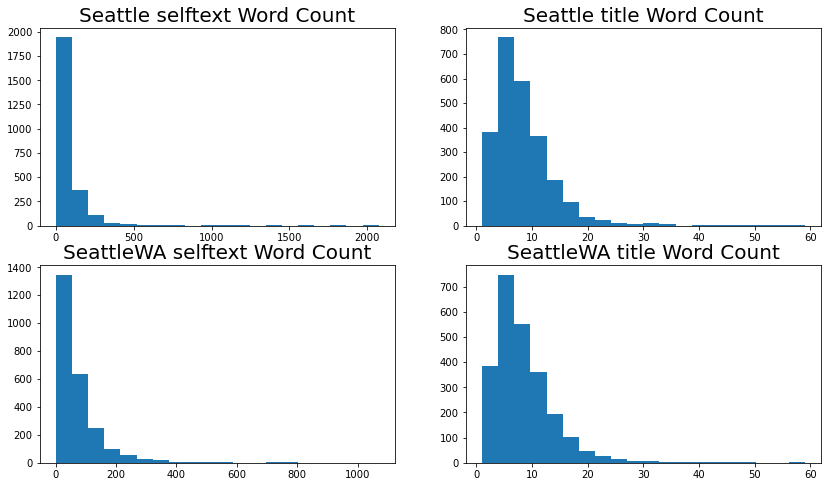

In [146]:
plt.figure(figsize = (14,8))

# iterator for subp
i = 1
for subreddit in [sea, sea_wa]:
    for col in ['selftext', 'title']:
        plt.subplot(2,2,i)
        plt.title(f"{subreddit['subreddit'].iloc[0]} {col} Word Count", size = 20)
        plt.hist(subreddit[col].str.split().str.len(), bins = 20);
        
        i += 1

In [93]:
# boolean list of entries with fewer than 5 'words' in Seattle
sea_selftext_lt5 = (sea['selftext'].str.split().str.len() <= 5)
sea_title_lt5 = (sea['title'].str.split().str.len() <= 5)

# boolean list of entries with fewer than 5 'words' in SeattleWA
sea_wa_selftext_lt5 = (sea_wa['selftext'].str.split().str.len() <= 5)
sea_wa_title_lt5 = (sea_wa['title'].str.split().str.len() <= 5)

# print number of posts removed from filtering
print(f'{len(sea[sea_selftext_lt5 & sea_title_lt5])} posts removed from r/Seattle')
print(f'{len(sea_wa[sea_wa_selftext_lt5 & sea_wa_title_lt5])} posts removed from r/SeattleWA')

#filter out posts with fewer than 5 words in selftext and title
sea = sea[(~sea_selftext_lt5) & (~sea_title_lt5)].copy()
sea_wa = sea_wa[(~sea_wa_selftext_lt5) & (~sea_wa_title_lt5)].copy()

11 posts removed from r/Seattle
29 posts removed from r/SeattleWA


This did not remove many posts, but was performed out of an abundance of caution.

We could also explore posts with large word counts, but there is little reason to be suspicious of such posts. Although more rare, the occassional lengthy post is fairly expected.

In [168]:
sea.loc[sea['selftext'].str.split().str.len() > 1500, 'selftext'].shape

(5,)

In [169]:
i = 0
for entry in sea.loc[sea['selftext'].str.split().str.len() > 1500, 'selftext']:
    print(f'{i}: ---------\n-------------\n-------------\n')
    print(entry, '\n')
    i += 1

0: ---------
-------------
-------------

Reddit:

Hey everyone! I just wanted to introduce myself again. My name is George, and I am a rising junior at Stanford interested in civic engagement and politics. I started working on a project with other students that’s been totally awesome and cool. Basically, we’ve made a newsletter that summarizes the info from Seattle City Council meetings in an accessible and easy way. I have put an example from this week below, though the real thing has a bit more formatting that doesn't translate into Reddit. This project is very new, so we would really appreciate any feedback you may have! I would love to see comments and show me what I need to do to make this newsletter the best it can be. I totally recommend joining! Who doesn’t want to know what goes on behind the scenes of their own beautiful city? If you are interested in receiving these weekly in your email inbox, you can click this link: [https://forms.gle/Yxo5fevVhVWmwcB78](https://forms.gle/

---

## Feature Engineering

Before we perform any string vectorization, let us perform some basic feature engineering. Our plan is to:
- combine title and selftext columns for a single column to vectorize
- create a word count column
- create a sentiment column

#### Combine `title` and `selftext`

In [94]:
# create a new column from joining title text and selftext
sea['text'] = sea['title'] + ' ' + sea['selftext']
sea_wa['text'] = sea_wa['title'] + ' ' + sea_wa['selftext']

#### Create a `word_count` Column

In [95]:
sea['word_count'] = sea['text'].str.split().str.len()
sea_wa['word_count'] = sea_wa['text'].str.split().str.len()

#### Create Sentiment Columns

In [96]:
sent = SentimentIntensityAnalyzer()

In [97]:
sea['sent_pos'] = sea['text'].map(lambda x: sent.polarity_scores(x)['pos'])
sea['sent_neg'] = sea['text'].map(lambda x: sent.polarity_scores(x)['neg'])

sea_wa['sent_pos'] = sea_wa['text'].map(lambda x: sent.polarity_scores(x)['pos'])
sea_wa['sent_neg'] = sea_wa['text'].map(lambda x: sent.polarity_scores(x)['neg'])

---

## Predicting From Strictly Text Data

When we look at self text with fewer than three spaces they consist of:
- emojis,
- links,
- '\[deleted\]'
- some variations on 'title' or 'thank you' or '...'

It seems reasonable to assume that posts corresponding to the last bullet have a more thorough title. It is probably fine to keep these rows. The string vectorizers drop emojis unless we tell it not to, so we do not have to worry about them for now. The deleted entry should be removed.

It is harder to know what to do with links. Let us explore this a bit more thoroughly after performing some light cleaning.

Another thing to notice is that some links, 'deleted', and 'removed' are wrapped in square brackets. We explore this below to see if this unveils anything we should deal with.

In [255]:
sea.loc[(sea['selftext'].str.contains('\[')) & (sea['selftext'].str.len() < 300), 'selftext'].head(20)

269     It's Banned Books Week - [https://www.thenewst...
458     This guy just flew over me super low and accor...
660     [https://www.kuow.org/stories/making-good-prog...
750     As we enter the third missed day of school it'...
873                                               [Title]
926     [Desk in question](https://www.ikea.com/us/en/...
1190    Looking to park overnight a few nights while l...
1292    [https://youtu.be/DMNSvHswljM](https://youtu.b...
1498    Got about 20 paintings I made a while back tha...
1735    There is a ton of balanced and accurate info [...
1766    [https://www.kuow.org/stories/seattle-passes-p...
1810    [Festival Lineup](https://i.imgur.com/sSUkny1....
1903    What are some of your hacks and pro tips? Whet...
2137    [https://content.govdelivery.com/bulletins/gd/...
2303    [https://www.scribd.com/document/232200355/Upd...
2337                                            [deleted]
2381    [like this one for LA](https://www.lataco.com/...
Name: selftext

In [252]:
sea.loc[926, 'selftext']

"[Desk in question](https://www.ikea.com/us/en/p/trotten-desk-sit-stand-white-s79429602/)\n\nI bought it just 6 months ago but upgraded. It has a lever for the height adjustment. It's fully assembled."

In [254]:
sea.loc[1190, 'selftext']

'Looking to park overnight a few nights while lodging in Belltown. Where’s the closest neighborhoods to park for free? [cat tax ](https://imgur.com/a/TMVxjEQ)'

In [253]:
sea.loc[1292, 'selftext']

'[https://youtu.be/DMNSvHswljM](https://youtu.be/DMNSvHswljM)'